# Advanced ML Project
---

## Summary

1. **Transformers with Attention Mechanisms**
    - **Project**: Develop a specialized Transformer model to capture long-term dependencies and temporal relationships in financial data, based on "Attention is All You Need" by Vaswani et al. (2017). We could also use the Temporal Fusion Transformer (TFT) for its efficiency with multi-horizon series, as presented by Lim et al. in "Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting" (2021).
    - **Objective**: Improve prediction accuracy by using attention mechanisms to capture the influences of distant data points.

2. **Variational Autoencoders (VAE) for Feature Engineering and Anomaly Detection**
    - **Project**: Use VAEs to compress market data and extract latent representations less sensitive to noise, inspired by "Auto-Encoding Variational Bayes" by Kingma and Welling (2013). We will also explore VAE-based approaches for anomaly detection in time series, as detailed in "Robust Anomaly Detection for Multivariate Time Series through Stochastic Recurrent Neural Network" by Hundman et al. (2018).
    - **Objective**: Extract robust latent features and detect anomalies to improve predictions and identify unexpected market variations.

3. **Performance Comparison**
    - **Objective**: Compare the performance of the two methods (Transformers vs VAE) for time series forecasting.

4. **Hyperparameter Fine-Tuning**
    - **Objective**: Fine-tune the model hyperparameters to optimize prediction performance.

https://github.com/xuxu-wei/HybridVAE

In [747]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import seaborn as sns

In [623]:
from transformers import TimeSeriesTransformerForPrediction
#from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.loggers import TensorBoardLogger


## Loading data

In [748]:
df = pd.read_parquet('../preprocessed_data/training.parquet').dropna()
test_df = pd.read_parquet('../preprocessed_data/test.parquet')

In [749]:
# Samples to try the algo
df_small = df.iloc[-1000000:].reset_index(drop=True)
test_df_small = test_df.dropna().sample(40000).reset_index(drop=True)

In [750]:
max_encoder_length = 50  # lookback window
max_prediction_length = 10  # forecast window

In [751]:
df_small["symbol_id"] = df_small["symbol_id"].astype("str")
test_df_small["symbol_id"] = test_df_small["symbol_id"].astype("str")

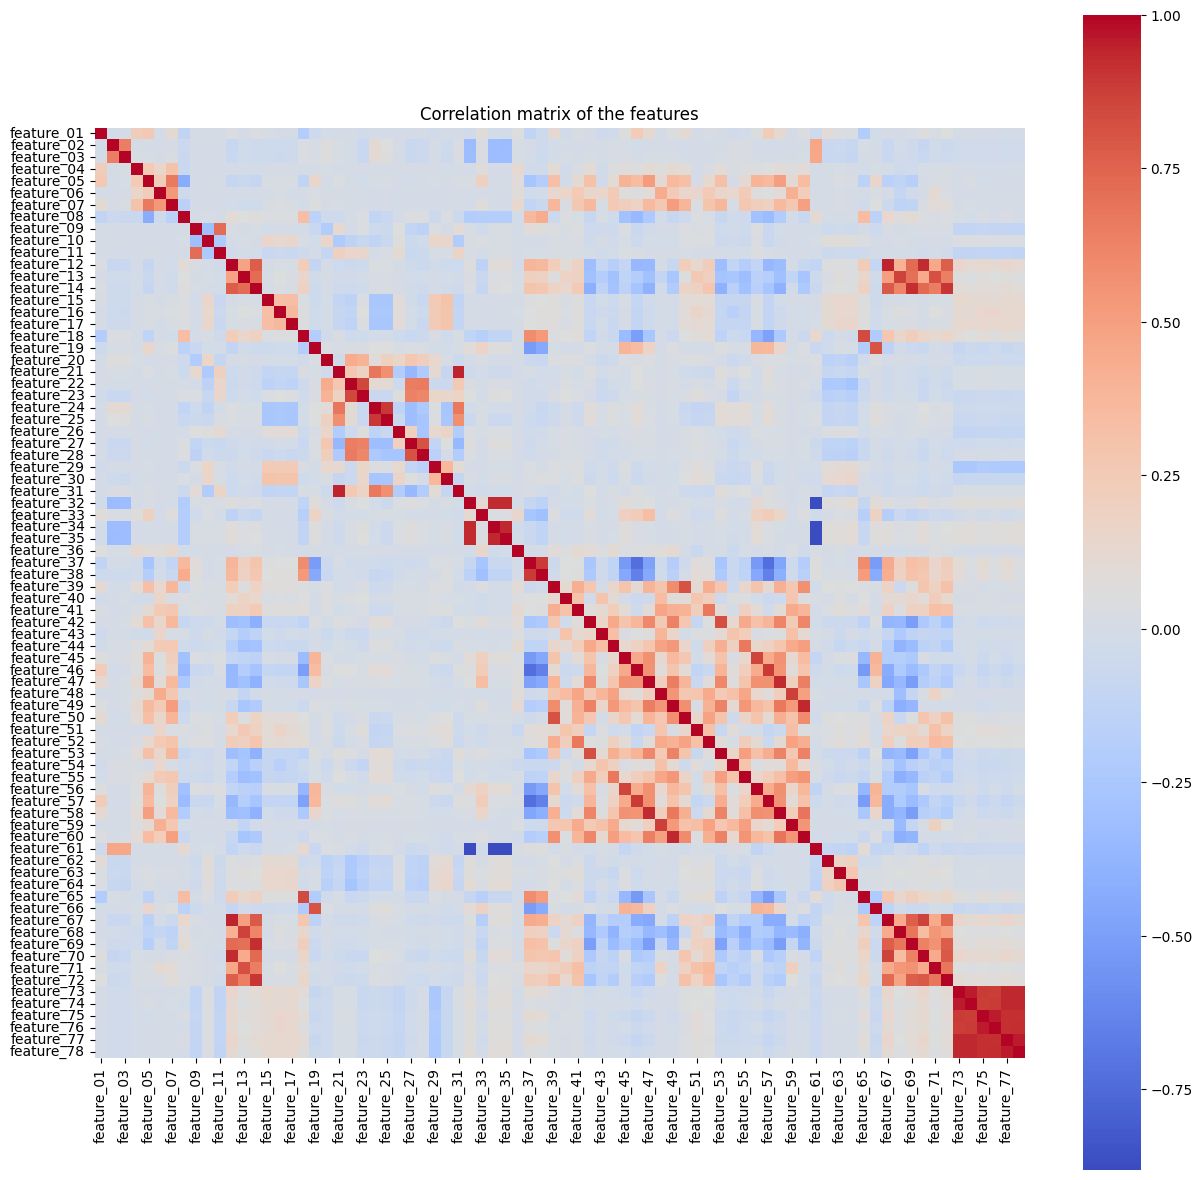

In [752]:
feature_correlation = test_df_small[[f"feature_0{i}" for i in range(1,10)]+[f"feature_{i}" for i in range(10,79)]].corr().fillna(0)
plt.figure(figsize = (15, 15))
sns.heatmap(feature_correlation, square = True, cmap = 'coolwarm')
plt.title("Correlation matrix of the features")
plt.show()

Based on this matrix, to avoid multicolinearity, we will drop features from 72 to 77 and keep only 78. As well we will drop features number 22,24,27,34 and 61.

In [753]:
features_to_drop = [f"feature_{i}" for i in [22,24,27,34,61,72,73,74,75,76,77]]

In [754]:
df_small = df_small.drop(columns=features_to_drop)
test_df_small = test_df_small.drop(columns=features_to_drop)

## Benchmark linear regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
benchmark = LinearRegression()
benchmark.fit(df_small.drop(columns=["label"]), df_small["label"])

LinearRegression()

In [33]:
r_sq = benchmark.score(test_df_small.drop(columns=["label"]), test_df_small["label"])
print('coefficient of determination:', r_sq)

coefficient of determination: 0.6959391160061761


In [34]:
y_pred = benchmark.predict(test_df_small.drop(columns=["label"]))
rms = mean_squared_error(test_df_small["label"], y_pred)
rms

0.38671048956829474

## Training Temporal Fusion Transformers

### Creation of an unique time id column for TimeSeriesDataSet

In [755]:
def create_unique_id(data,test_data):

    mapping = pd.DataFrame(pd.concat([data,test_data]).groupby(['date_id','time_id']).count().index,columns=["date_time"]).reset_index().rename(columns={"index":"time_idx"})

    data["date_time"] = list(zip(data["date_id"], data["time_id"]))
    data["time_idx"] = data["date_time"].map(dict(zip(mapping["date_time"], mapping["time_idx"])))

    test_data["date_time"] = list(zip(test_data["date_id"], test_data["time_id"]))
    test_data["time_idx"] = test_data["date_time"].map(dict(zip(mapping["date_time"], mapping["time_idx"])))

    first_val = data["time_idx"].min()

    data["time_idx"] = data["time_idx"] - first_val
    test_data["time_idx"] = test_data["time_idx"] - first_val

    columns_to_drop = ["id","date_id",'time_id',"date_time"]
    data = data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)
    return data, test_data

In [756]:
df_small, test_df_small = create_unique_id(df_small, test_df_small)

In [757]:
time_varying_unknown_reals = df_small.drop(columns=["label","symbol_id","time_idx"]).columns.to_list()

### Dataloader creation

In [759]:
training = TimeSeriesDataSet(
    df_small,
    time_idx="time_idx",
    target="label",
    group_ids=["symbol_id"],
    min_encoder_length=max_encoder_length // 2,  # allow predictions without full history
    max_encoder_length=max_encoder_length,
    min_prediction_idx=0,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol_id"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    #target_normalizer=GroupNormalizer(transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:572: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [760]:
train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=0)
validation = TimeSeriesDataSet.from_dataset(training, df_small, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)


### Model creation and fit

In [762]:
class LossTrackingCallback(pl.Callback):
    def __init__(self):
        # Initialize variable to track the losses
        self.val_losses = []
        self.val_rmse = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.callback_metrics.get('val_MAE') is not None:
            self.val_losses.append(trainer.callback_metrics['val_MAE'].item())
        if trainer.callback_metrics.get('val_RMSE') is not None:
            self.val_rmse.append(trainer.callback_metrics['val_RMSE'].item())

    def on_train_end(self, trainer, pl_module):
        pd.DataFrame({"val_mae" : self.val_losses, "val_rmse":self.val_rmse}).to_csv("losses_rmse.csv")

loss_tracking_callback = LossTrackingCallback()


In [763]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=20, verbose=False, mode="min")

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="best-checkpoint",
    save_top_k=1,  
    monitor="val_loss", 
    mode="min", 
)


In [765]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    #gradient_clip_val=0.1,
    limit_train_batches=0.25,  
    val_check_interval=0.01,
    callbacks=[early_stop_callback, checkpoint_callback, loss_tracking_callback],
)

In [768]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=32,
    attention_head_size=8,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(quantiles=[0.5]), # corresponds to MAE
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Number of parameters in network: 142.7k


The fit takes a lot of time

In [769]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 456    | train
3  | prescalers                         | ModuleDict                      | 1.1 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 87.7 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 896    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Epoch 0:   5%|▍         | 97/1956 [02:04<39:36,  0.78it/s, v_num=139, train_loss_step=0.600, val_loss=0.394]

In [647]:
val_losses = pd.read_csv("losses_rmse.csv")
val_losses

,Unnamed: 0,val_mae,val_rmse
0,0,4.456528,4.526052
1,1,1.109819,1.258458
2,2,0.441969,0.791496
3,3,0.402252,0.790616
4,4,0.390984,0.791309
5,5,0.415792,0.790323
6,6,0.392239,0.791631
7,7,0.416156,0.794030
8,8,0.412945,0.790320
9,9,0.405427,0.792795


In [648]:
val_losses["epoch_fract"] = [trainer.val_check_interval*i for i in range(1,len(val_losses)+1)]

Text(0.5, 1.0, 'Validation MAE in function of the epochs')

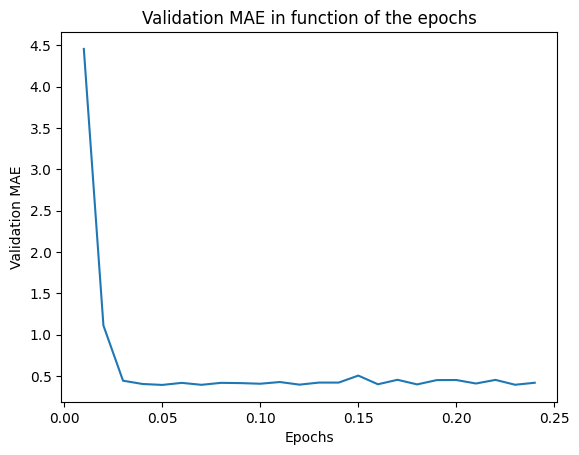

In [649]:
plt.plot(val_losses["epoch_fract"], val_losses["val_mae"])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Validation MAE in function of the epochs")

In [650]:
trainer.checkpoint_callback.best_model_path

'/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/code/checkpoints/best-checkpoint-v11.ckpt'

In [651]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### Test set prediction

In [653]:
test_DS = TimeSeriesDataSet.from_dataset(training, test_df_small, predict=True, stop_randomization=True)
test_DL = test_DS.to_dataloader(train=False, batch_size=100, num_workers=0)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__symbol_id': '10'}]
  warnings.warn(


In [ ]:
predictions = best_tft.predict(test_DL, return_y=True)
RMSE()(predictions.output, predictions.y).item()

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


1.3190633058547974

In [674]:
torch.mean(predictions.y[0].float())

tensor(9.9622)

In [661]:
predictions.output

tensor([[9.9931, 9.9949, 9.9961, 9.9968, 9.9974, 9.9979, 9.9985, 9.9990, 9.9994,
         9.9998],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9994,
         9.9999],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9995,
         9.9999],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9994,
         9.9999],
        [9.9931, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9995,
         9.9999],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9994,
         9.9999],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9994,
         9.9998],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9994,
         9.9999],
        [9.9932, 9.9950, 9.9961, 9.9968, 9.9974, 9.9980, 9.9985, 9.9990, 9.9995,
         9.9999],
        [9.9933, 9.9950, 9.9962, 9.9969, 9.9975, 9.9980, 9.9986, 9.9991, 9.9995,
         9.9999],
        [9

In [695]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


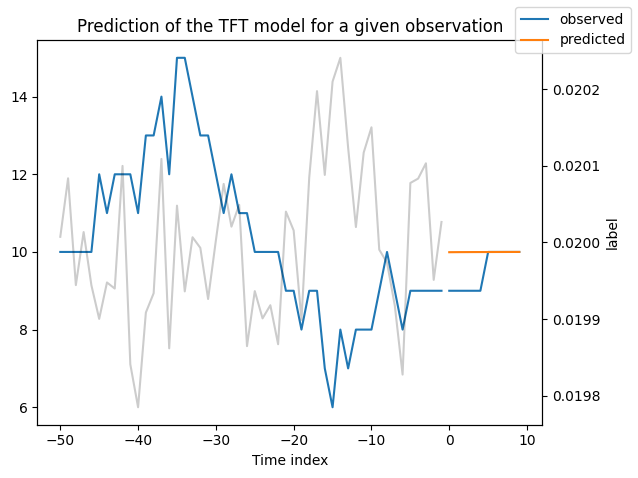

In [ ]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=5, add_loss_to_title=False)
plt.ylabel("label")
plt.title("Prediction of the TFT model for a given observation")
plt.tight_layout()
plt.show()


### Test on only one symbol_id (one asset)

In [716]:
df_symbol = df[df["symbol_id"] == 33]
test_df_symbol = test_df[test_df["symbol_id"] == 33]

In [737]:
test_df_symbol.dropna(inplace=True)

In [717]:
df_symbol.drop(columns=features_to_drop, inplace=True)
test_df_symbol.drop(columns=features_to_drop, inplace=True)

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_75664/1208931589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_symbol.drop(columns=features_to_drop, inplace=True)
/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_75664/1208931589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_symbol.drop(columns=features_to_drop, inplace=True)


In [718]:
df_symbol, test_df_symbol = create_unique_id(df_symbol, test_df_symbol)

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_75664/1447040392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date_time"] = list(zip(data["date_id"], data["time_id"]))
/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_75664/1447040392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_idx"] = data["date_time"].map(dict(zip(mapping["date_time"], mapping["time_idx"])))
/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_75664/1447040392.py:8: SettingWithCopy

In [719]:
df_symbol.drop(columns=["weight"],inplace=True)
test_df_symbol.drop(columns=["weight"],inplace=True)

In [720]:
time_varying_unknown_reals = df_symbol.drop(columns=["label","time_idx"]).columns.to_list()

In [721]:
training_symbol = TimeSeriesDataSet(
    df_symbol,
    time_idx="time_idx",
    target="label",
    group_ids=["symbol_id"],
    min_encoder_length=max_encoder_length // 2,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_idx=0,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    #target_normalizer=GroupNormalizer(transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:572: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [722]:
train_symbol_dataloader = training_symbol.to_dataloader(train=True, batch_size=128, num_workers=0)
validation_symbol = TimeSeriesDataSet.from_dataset(training_symbol, df_symbol, predict=True, stop_randomization=True)
val_symbol_dataloader = validation_symbol.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

In [732]:
early_stop_callback_symbol = EarlyStopping(monitor="val_loss", patience=20, verbose=False, mode="min")

checkpoint_callback_symbol = ModelCheckpoint(
    dirpath="checkpoints_symbol/",
    filename="best-checkpoint",
    save_top_k=1,  
    monitor="val_loss", 
    mode="min", 
)


In [733]:
trainer_symbol = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    #gradient_clip_val=0.1,
    limit_train_batches=0.25,  
    val_check_interval=0.01,
    callbacks=[early_stop_callback_symbol, checkpoint_callback_symbol],
)

In [734]:
tft_symbol = TemporalFusionTransformer.from_dataset(
    training_symbol,
    learning_rate=0.01,
    hidden_size=16,
    #attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(quantiles=[0.5]), # corresponds to MAE
)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. Fr

In [735]:
trainer_symbol.fit(
    tft_symbol,
    train_dataloaders=train_symbol_dataloader,
    val_dataloaders=val_symbol_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 1.1 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 528    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 49.2 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:  29%|██▉       | 68/231 [00:49<01:57,  1.38it/s, v_num=136, train_loss_step=0.780, val_loss=1.260, train_loss_epoch=2.740]


In [738]:
test_DS_symbol = TimeSeriesDataSet.from_dataset(training_symbol, test_df_symbol, predict=True, stop_randomization=True)
test_DL_symbol = test_DS_symbol.to_dataloader(train=False, batch_size=100, num_workers=0)

In [739]:
best_model_path_symbol = trainer_symbol.checkpoint_callback.best_model_path
best_tft_symbol = TemporalFusionTransformer.load_from_checkpoint(best_model_path_symbol)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [740]:
predictions_symbol = best_tft_symbol.predict(test_DL_symbol, return_y=True)
RMSE()(predictions_symbol.output, predictions_symbol.y).item()

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


1.4064913988113403

In [742]:
predictions.y

(tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [11, 11, 11, 12, 12, 12, 12, 12, 12, 13],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [ 7,  7,  9,  9,  9,  9,  9,  9,  9, 10],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [10, 10, 10, 11, 11, 11, 11, 11, 11, 12],
         [ 9,  9,  9, 10, 11, 11, 11, 11, 11, 10],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [12, 12, 12, 12, 12, 12, 12, 10, 10, 10],
         [ 8,  8,  8,  8,  8,  8,  8, 10, 10, 10],
         [11, 11, 11, 11, 11, 11, 11, 11, 11, 10],
         [13, 13, 13, 13, 13, 13, 10, 10, 10, 10],
         [12, 12, 12,  8,  8,  8,  8,  8,  8,  8],
         [ 7,  7,  7,  7,  7,  7,  7,  7,  7, 10],
         [ 8,  8,  8, 11, 11, 11, 10, 10, 11, 11],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [ 7,  7,  7,  7,  7,  9,  9, 10, 10,  8],
         [10, 10, 10, 10, 10, 1

### Tune HP

In [771]:
import pickle


# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=0.15),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-01-16 18:33:43,871] A new study created in memory with name: no-name-a67aacc9-ee9d-4a17-8ed3-cc77f4c74273
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout_range),
/Users/paul-antoine/Desk

KeyError: 'val_loss'